In [143]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import math
import numpy as np
import cmdstanpy
import pandas as pd
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats

from plots import plot_posterior_time_series
from measurements import form_table, display_measurements
from distributions import plot_invgammas, plot_lognormals
import samples

# matplotlib.style.use('seaborn-poster')
matplotlib.style.use('ggplot')

## Population info

In [26]:
# worldometer.com, just took the current ones.  these numbers can be pretty approximate.
populations = {
    'Italy':60488135,
    'China':1435000000,
    'Korea, South':51256309,
    'Spain':46749498,
    'US':331002651,
    'Australia':25411689,
    'Iran':83671720,
    'France':65231249,
    'Germany':83706861,
    'India':1376085273,
    'Russia':145916728,
}

# Running simulations

The first step is to simulate a bunch of measurements to ensure our model is doing roughly what we expect.

In [206]:
sim_config = {
    'start_index':0,
    'start_at_infections':50,
    'start_at_deaths':5,
    'country':'Australia',
    'model_name':'sird_reduced_simulate.stan',
}

sim_day_count = 30
sim_y0 = np.array([sim_config['start_at_infections'], 10, sim_config['start_at_deaths']])
sim_data = {
    # These initial conditions can be drawn from actual data as desired
    'y0':sim_y0,
    'T':sim_day_count,
    'ts':list(range(0, sim_day_count)),
    'population':populations[sim_config['country']],
    'sigma_infected':2,
    'sigma_dead':1,
    'beta':0.12,
    'gamma':0.004,
    'zeta':0.001,
}

In [226]:
sim_model = cmdstanpy.CmdStanModel(stan_file=sim_config['model_name'])

sim_results = sim_model.sample(data=sim_data,
                       # show_progress='notebook',
                       # Use a fixed seed so that our runs are deterministic.
                       seed=2222,
                       # This computer has 24 cores/48 threads; 24 chains is plenty
                       cores=24,
                       chains=24,
                       # Make sure to get enough samples to avoid any diagnostic problems
                       iter_sampling=300,
                       fixed_param=True)

# Generate a run summary
_ = samples.run_validate_stan(sim_results, ())

INFO:cmdstanpy:compiling stan program, exe file: /home/peddie/programming/covid19-modelling/sird_reduced_simulate
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/peddie/programming/covid19-modelling/sird_reduced_simulate
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:start chain 5
INFO:cmdstanpy:start chain 6
INFO:cmdstanpy:start chain 7
INFO:cmdstanpy:start chain 8
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 9
INFO:cmdstanpy:start chain 10
INFO:cmdstanpy:start chain 11
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 12
INFO:cmdstanpy:start chain 13
INFO:cmdstanpy:start chain 14
INFO:cmdstanpy:start chain 15
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:start chain 16
INFO:cmdstanpy:start chain 17
INFO:cmdstanpy:start chain 18
INFO:cmdstanpy:finish chain 5
INFO:cmdstanpy:start chain 19
INFO

This plot shows the simulated noisy measurements.

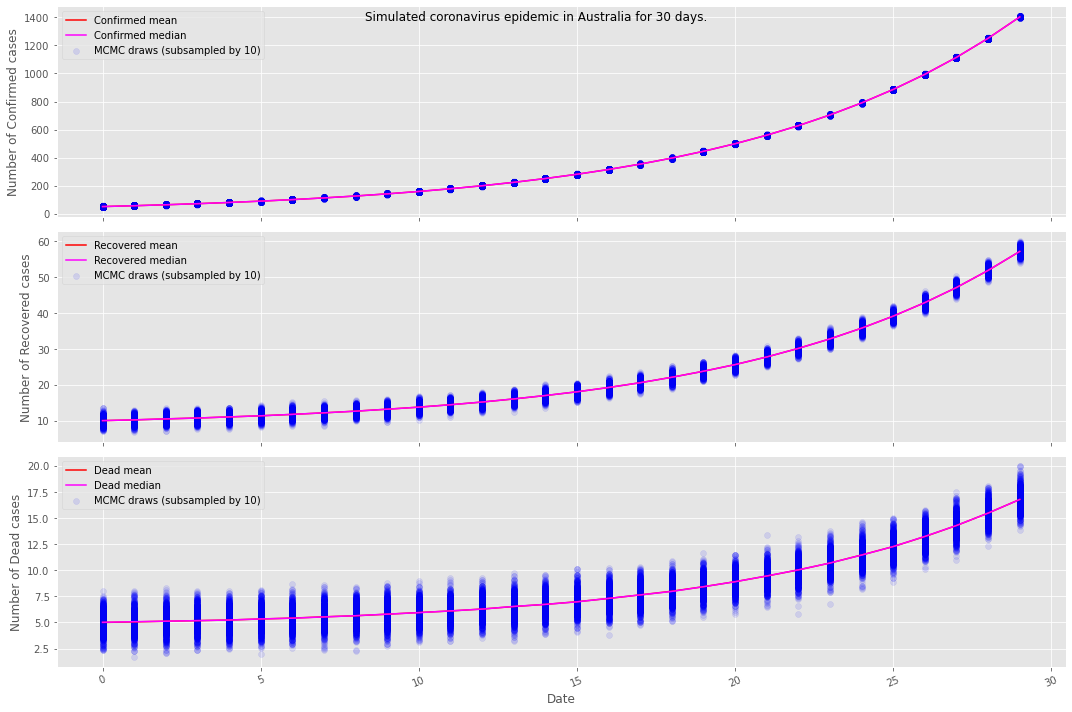

In [227]:
sim_samples = samples.get_sample_time_series(sim_results)
plot_posterior_time_series(sim_samples, None, sim_config, sample_points_only=True)

# Visualizing the prior

I heard that the prior can only be understood in the context of the likelihood.  Let's try to understand our prior.

It's handy to be able to visualize a few distributions when assigning priors.

e^(0.1 + 0.01^2/2) = 1.1052261780030381
e^(0.2 + 0.01^2/2) = 1.2214638298248568


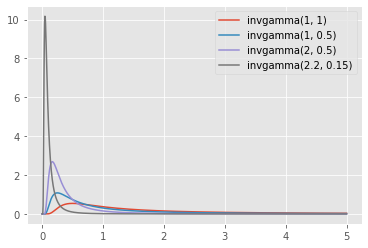

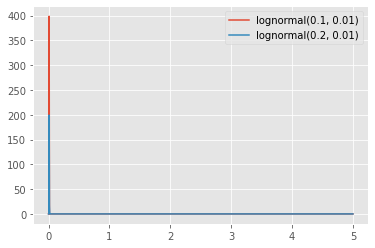

In [228]:
plot_invgammas([(1, 1), (1, 0.5), (2, 0.5), (2.2, 0.15)])
plot_lognormals([(1e-1, 1e-2), (2e-1, 1e-2)])

In [229]:
prior_data = {
    ## Parameters
    'y':sim_samples[0, :, :].transpose(),
    'T':sim_day_count,
    'ts':list(range(0, sim_day_count)),
    'population':populations[sim_config['country']],
    # inverse gamma
    'sigma_infected_prior':[2, 0.3],
    # inverse gamma
    'sigma_dead_prior':[2, 0.2],
    # inverse gamma
    'beta_prior':[0, 0.2],
    # normal
    'gamma_prior':[0, 1e-2],
    # normal
    'zeta_prior':[0, 1e-3],
}

# We want to examine a run summary and look at posteriors and so on for these parameters
important_values = (
    'lp__',
    'beta',
    'gamma',
    'zeta',
    'sigma_infected',
    'sigma_dead',
) 

# We can't look for 'lp__' in the posterior stuff
analysis_variables=list(filter(lambda x: x != 'lp__', important_values))

See the comments about how to run the sampler.  We always generate a run summary every time we run this cell.  Its results should always be examined before proceeding to any other analysis.

In [230]:
prior_model = cmdstanpy.CmdStanModel(stan_file='sird_reduced_prior.stan')

prior_fit = prior_model.sample(data=prior_data,
                         show_progress='notebook',
                         # Use a fixed seed so that our runs are deterministic.
                         seed=2222,
                         # This computer has 24 cores/48 threads; 24 chains is plenty
                         cores=24,
                         chains=24,
                         # Make the sampler a bit more robust in exchange for more sampling time
                         adapt_delta=0.9,
                         # Let the sampler explore deeper
                         # max_treedepth=12,
                         # Make sure to get enough samples to avoid any diagnostic problems
                         iter_sampling=300)

# Generate a run summary
samples.run_validate_stan(prior_fit, important_values)


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/peddie/programming/covid19-modelling/sird_reduced_prior


INFO:cmdstanpy:Processing csv files: /tmp/tmpvw8fuuom/sird_reduced_prior-202003242101-1-sgpk461t.csv, /tmp/tmpvw8fuuom/sird_reduced_prior-202003242101-2-_at__wks.csv, /tmp/tmpvw8fuuom/sird_reduced_prior-202003242101-3-4yrndi17.csv, /tmp/tmpvw8fuuom/sird_reduced_prior-202003242101-4-bit2dqqy.csv, /tmp/tmpvw8fuuom/sird_reduced_prior-202003242101-5-zzt89ib6.csv, /tmp/tmpvw8fuuom/sird_reduced_prior-202003242101-6-8lukqvxj.csv, /tmp/tmpvw8fuuom/sird_reduced_prior-202003242101-7-q_eldmah.csv, /tmp/tmpvw8fuuom/sird_reduced_prior-202003242101-8-01fo1br3.csv, /tmp/tmpvw8fuuom/sird_reduced_prior-202003242101-9-neu_ibvh.csv, /tmp/tmpvw8fuuom/sird_reduced_prior-202003242101-10-dsb7e_zw.csv, /tmp/tmpvw8fuuom/sird_reduced_prior-202003242101-11-a95bwh_q.csv, /tmp/tmpvw8fuuom/sird_reduced_prior-202003242101-12-wtubybp8.csv, /tmp/tmpvw8fuuom/sird_reduced_prior-202003242101-13-t3pu45cg.csv, /tmp/tmpvw8fuuom/sird_reduced_prior-202003242101-14-ereftuds.csv, /tmp/tmpvw8fuuom/sird_reduced_prior-202003242101

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-13.225600,0.039741,1.774660,-16.564200,-12.881700,-10.966300,1994.08,2228.99,1.007590
beta,0.159689,0.001605,0.120887,0.012557,0.134308,0.392968,5673.38,6341.72,1.000860
gamma,0.007880,0.000080,0.006093,0.000668,0.006542,0.019722,5802.92,6486.52,0.998913
zeta,0.000785,0.000008,0.000599,0.000058,0.000666,0.001944,4970.64,5556.19,1.001100
sigma_infected,0.296406,0.010422,0.475037,0.063755,0.179213,0.852515,2077.51,2322.24,1.007240
sigma_dead,0.195827,0.006252,0.316640,0.042849,0.121041,0.563416,2565.42,2867.63,1.005990


## Prior visualization and analysis

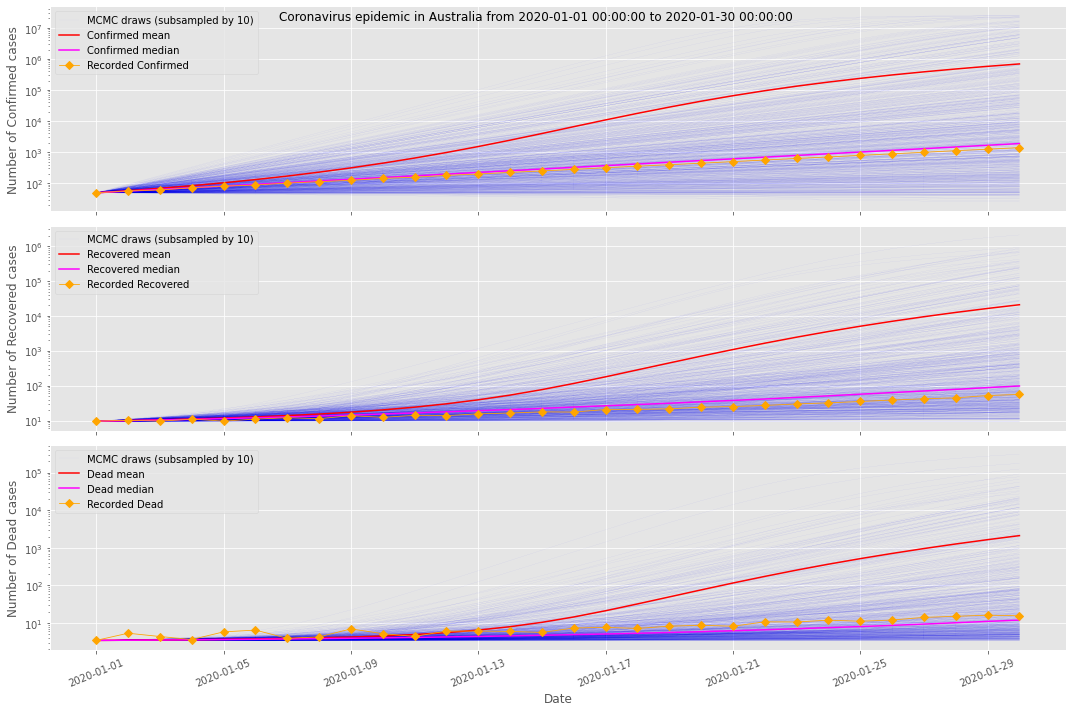

-3.240817981078918e+16 0


In [231]:
prior_samples = samples.get_sample_time_series(prior_fit)
sim_comparison = pd.DataFrame(sim_samples[0, :, :].transpose(), 
                              index=pd.date_range(start='1/1/20', periods=sim_day_count),
                              columns=['Confirmed', 'Recovered', 'Dead'])
plot_posterior_time_series(prior_samples, sim_comparison, sim_config, plot_log=True)
log_likelihoods = samples.compute_sample_log_likelihood(prior_fit)
print(np.mean(log_likelihoods), np.count_nonzero(np.isnan(log_likelihoods)))

#### Extended prior diagnostics

We'll use arviz to do some more diagnostic plots.

Displaying posterior plots.


/usr/local/lib/python3.8/dist-packages/arviz/plots/backends/matplotlib/pairplot.py:129: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.wspace'].  Set pad=0 to keep the old behavior.
  cax = divider.append_axes("left", size="7%")


Validating inference run.


/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:732: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:531: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:732: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:732: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


LOO analysis:
 Computed from 7200 by 90 log-likelihood matrix

         Estimate       SE
elpd_loo -624983341122871680.00  193292114675344544.00
p_loo    624983341122871296.00        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        2    2.2%
 (0.5, 0.7]   (ok)          1    1.1%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)   87   96.7%

Validating parameter sampling.


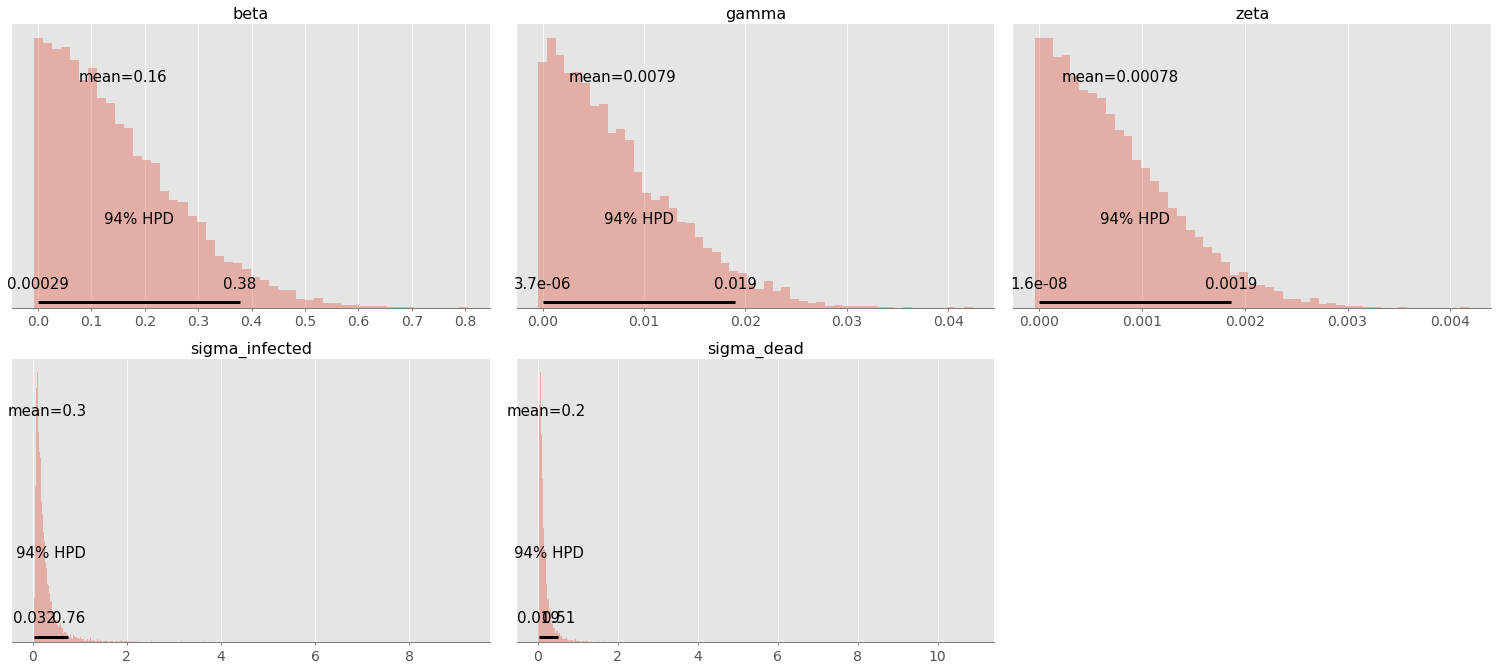

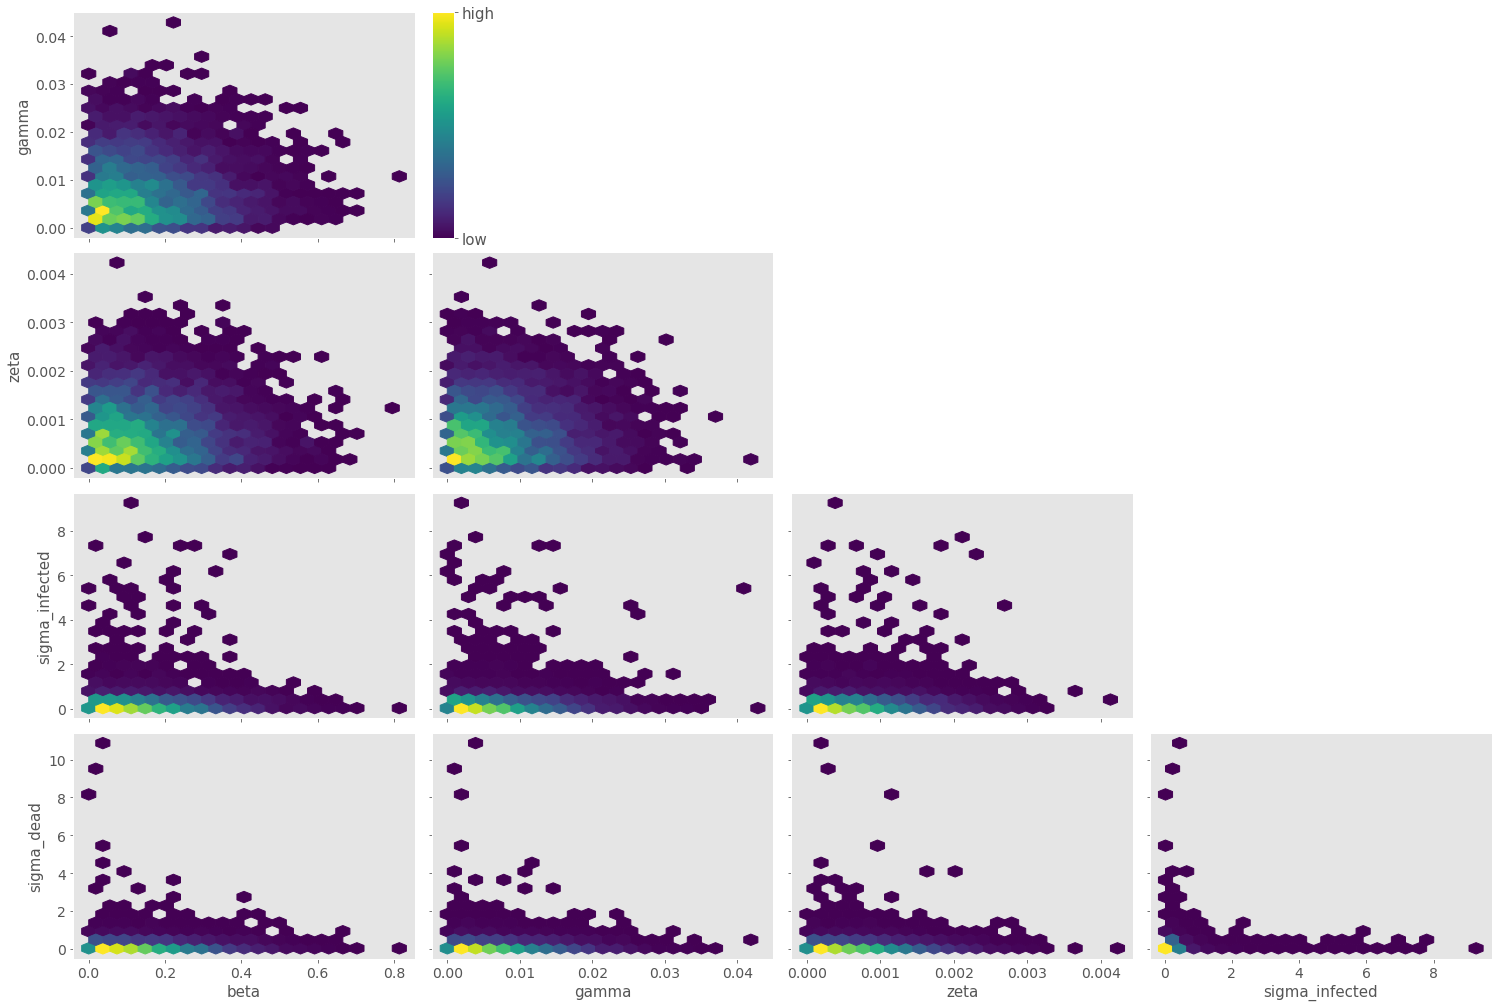

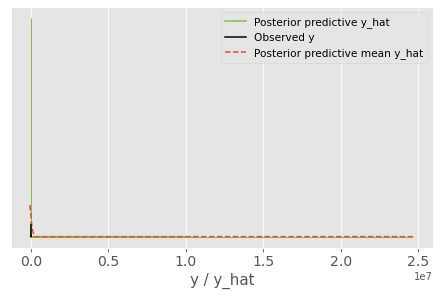

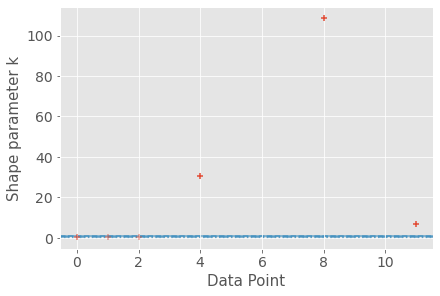

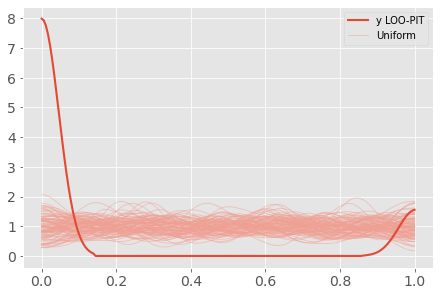

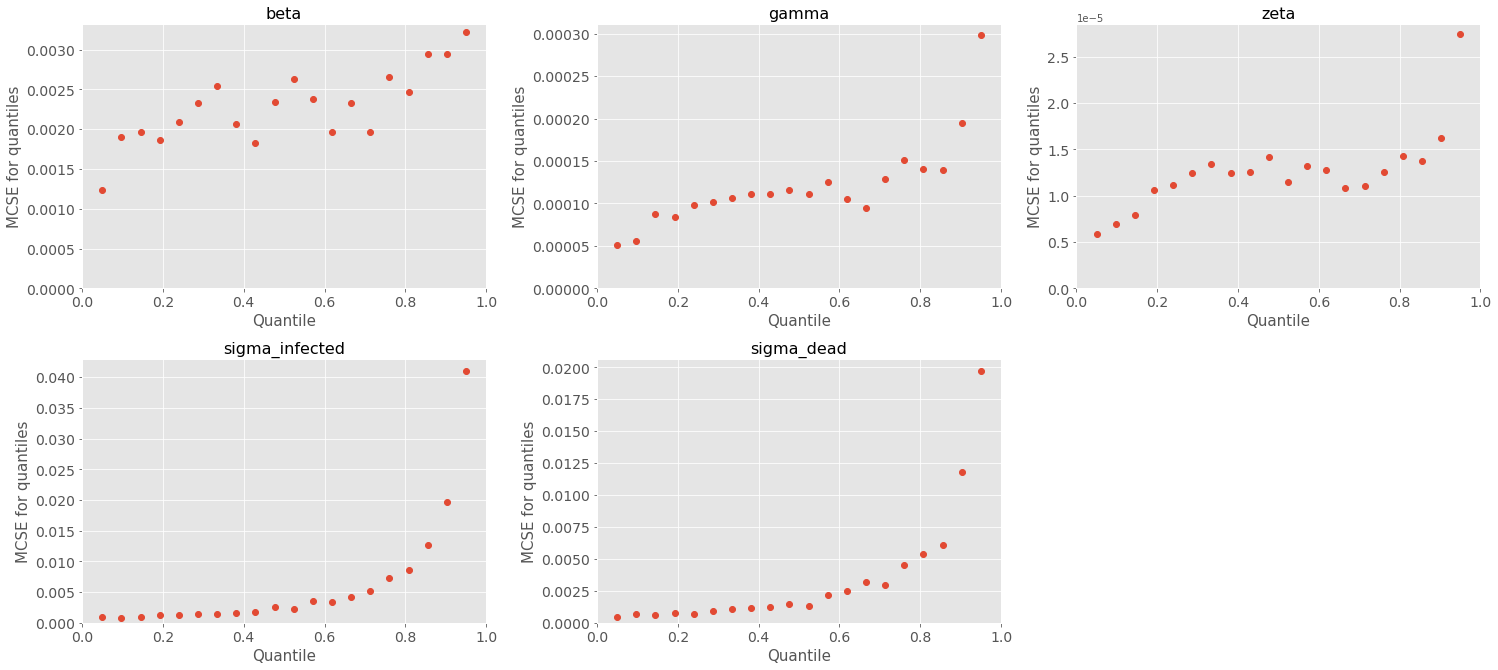

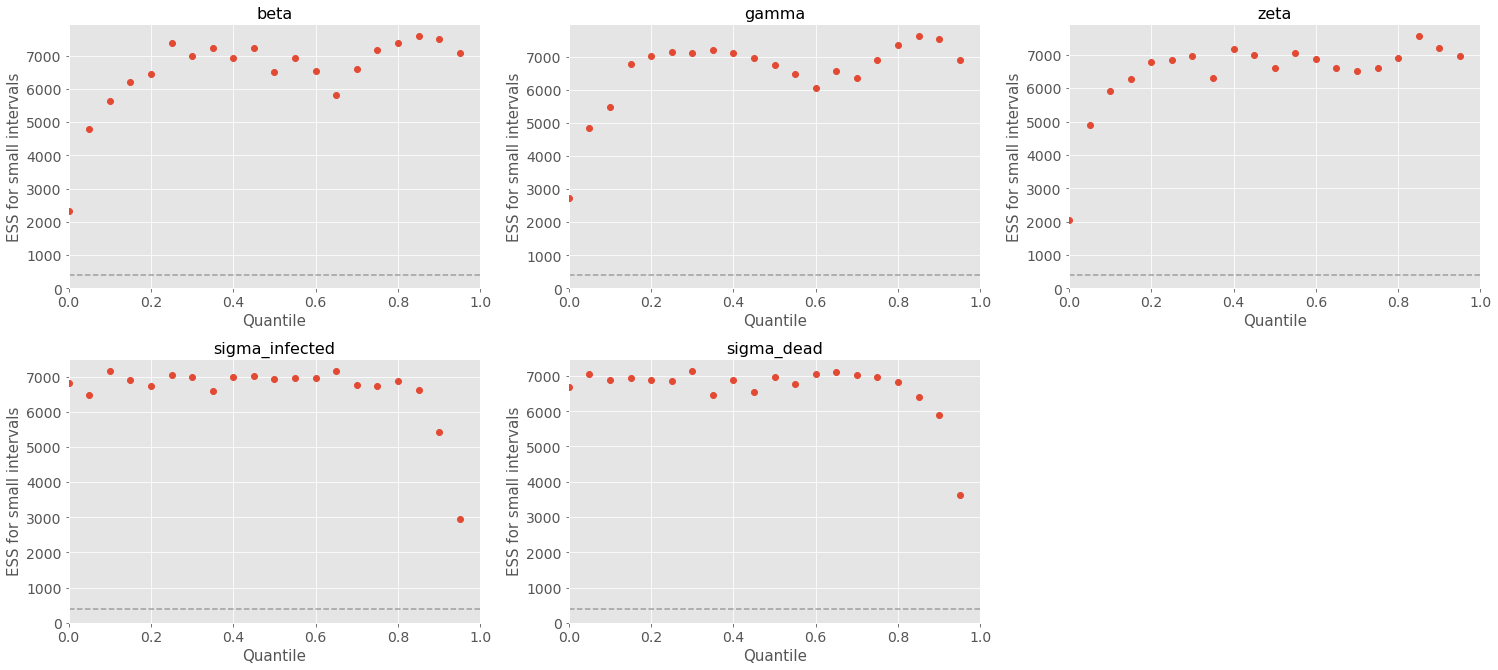

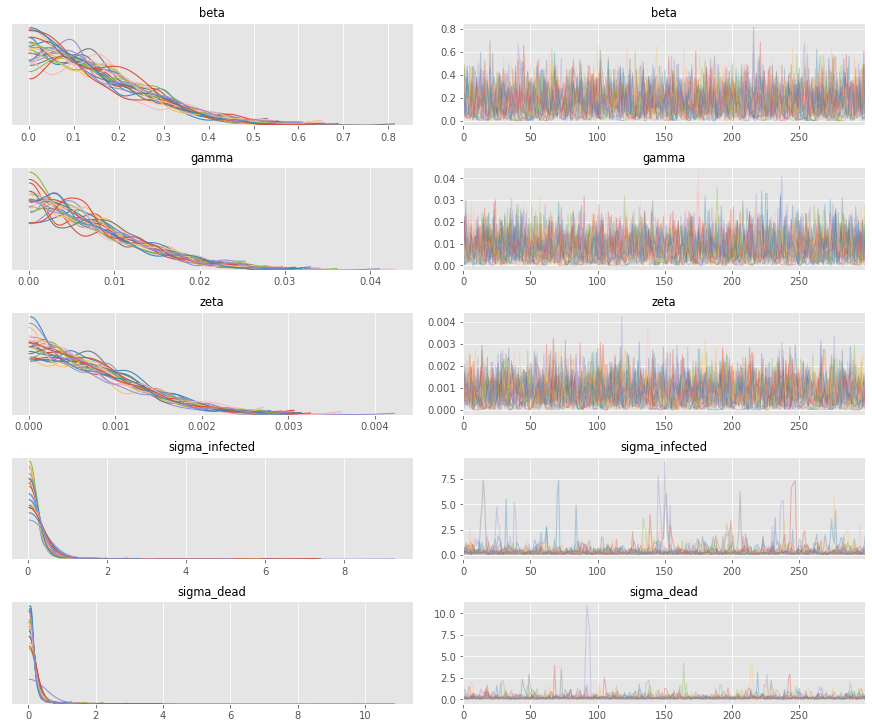

In [232]:
# TODO(MP): how do you plot log probability of the sample?  'lp__' is gone.
analysis_variables=list(filter(lambda x: x != 'lp__', important_values))
samples.standard_validate_arviz(prior_fit, 'log_likelihood', 'y_hat', sim_comparison.to_numpy(), analysis_variables)

# Inference on simulated data

This is the real test.

In [233]:
sim_fit_model = cmdstanpy.CmdStanModel(stan_file='sird_reduced.stan')

sim_fit = sim_fit_model.sample(data=prior_data,
                               show_progress='notebook',
                               # Use a fixed seed so that our runs are deterministic.
                               seed=2222,
                               # This computer has 24 cores/48 threads; 24 chains is plenty
                               cores=24,
                               chains=24,
                               # Make the sampler a bit more robust in exchange for more sampling time
                               adapt_delta=0.95,
                               # Let the sampler explore deeper
                               # max_treedepth=12,
                               # Make sure to get enough samples to avoid any diagnostic problems
                               iter_sampling=300)

# Generate a run summary
samples.run_validate_stan(sim_fit, important_values)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/peddie/programming/covid19-modelling/sird_reduced


INFO:cmdstanpy:Processing csv files: /tmp/tmpvw8fuuom/sird_reduced-202003242102-1-zxfc8lwj.csv, /tmp/tmpvw8fuuom/sird_reduced-202003242102-2-j24bdo1g.csv, /tmp/tmpvw8fuuom/sird_reduced-202003242102-3-ea15f5kj.csv, /tmp/tmpvw8fuuom/sird_reduced-202003242102-4-warv39kd.csv, /tmp/tmpvw8fuuom/sird_reduced-202003242102-5-hziq77ev.csv, /tmp/tmpvw8fuuom/sird_reduced-202003242102-6-esp7v29k.csv, /tmp/tmpvw8fuuom/sird_reduced-202003242102-7-vrxqnkdc.csv, /tmp/tmpvw8fuuom/sird_reduced-202003242102-8-1rxrlpy5.csv, /tmp/tmpvw8fuuom/sird_reduced-202003242102-9-vtxivtzr.csv, /tmp/tmpvw8fuuom/sird_reduced-202003242102-10-hq0b4uwg.csv, /tmp/tmpvw8fuuom/sird_reduced-202003242102-11-uprzvbsf.csv, /tmp/tmpvw8fuuom/sird_reduced-202003242102-12-vaf2_uf2.csv, /tmp/tmpvw8fuuom/sird_reduced-202003242102-13-m53hz8zk.csv, /tmp/tmpvw8fuuom/sird_reduced-202003242102-14-b3_f1lhd.csv, /tmp/tmpvw8fuuom/sird_reduced-202003242102-15-9jj7ehmf.csv, /tmp/tmpvw8fuuom/sird_reduced-202003242102-16-_jyx45ih.csv, /tmp/tmpvw8f

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-91.105700,2.966240e-02,1.588040,-94.114300,-90.795700,-89.156400,2866.21,97.4076,1.00544
beta,0.120735,9.044410e-07,0.000065,0.120628,0.120734,0.120840,5113.13,173.7690,1.00194
gamma,0.003998,5.498030e-07,0.000042,0.003928,0.003998,0.004067,5855.84,199.0090,1.00062
zeta,0.001256,6.059150e-07,0.000042,0.001188,0.001255,0.001327,4753.37,161.5420,1.00175
sigma_infected,2.308990,4.152520e-03,0.295019,1.880250,2.280700,2.833510,5047.50,171.5380,1.00074
sigma_dead,1.041080,1.348320e-03,0.096420,0.895378,1.034170,1.212720,5113.85,173.7930,1.00205


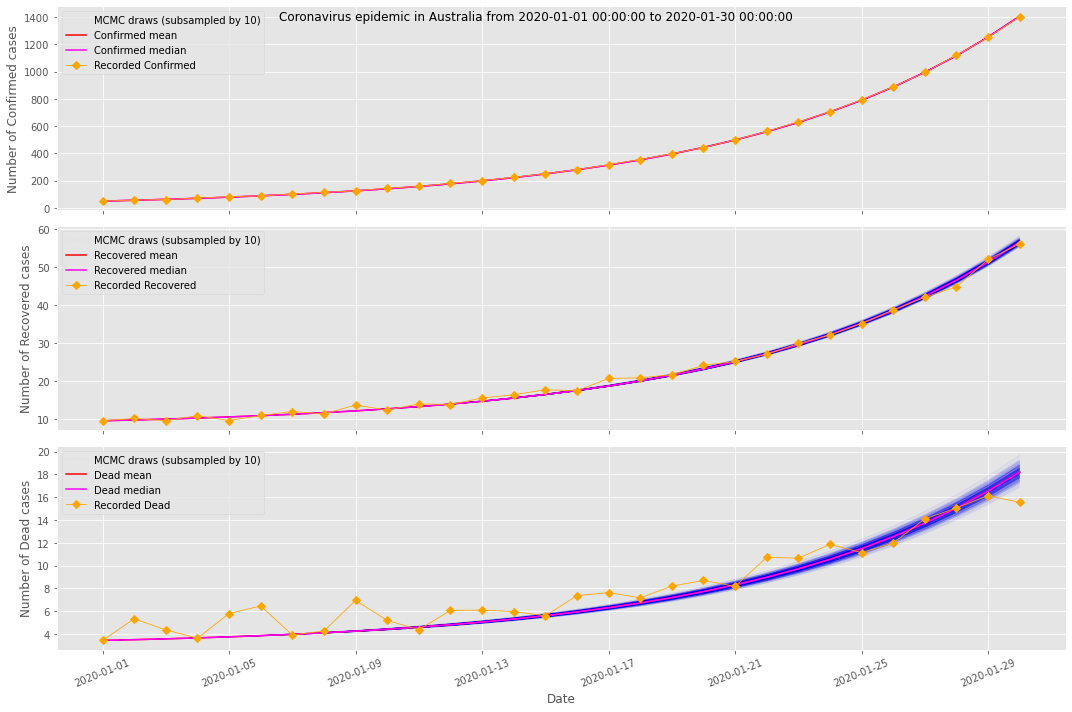

In [234]:
sim_fit_samples = samples.get_sample_time_series(sim_fit)
plot_posterior_time_series(sim_fit_samples, sim_comparison, sim_config)

In [235]:
sim_fit_summary = sim_fit.summary()
print("Errors in inference from simulated data:")
errors = pd.DataFrame(([sim_data[varname],
                        sim_fit_summary.loc[varname, 'Mean'],
                        np.abs(sim_data[varname] - sim_fit_summary.loc[varname, 'Mean'])]
                       for varname in analysis_variables),
                      columns=['Simulated value', 'Posterior mean', 'Error'],
                      index=analysis_variables)
print(errors)

Errors in inference from simulated data:
                Simulated value  Posterior mean     Error
beta                      0.120        0.120735  0.000735
gamma                     0.004        0.003998  0.000002
zeta                      0.001        0.001256  0.000256
sigma_infected            2.000        2.308990  0.308990
sigma_dead                1.000        1.041080  0.041080


#### Extended prior diagnostics

We'll use arviz to do some more diagnostic plots.

Displaying posterior plots.


/usr/local/lib/python3.8/dist-packages/arviz/plots/backends/matplotlib/pairplot.py:129: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.wspace'].  Set pad=0 to keep the old behavior.
  cax = divider.append_axes("left", size="7%")


Validating inference run.


/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:531: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


LOO analysis:
 Computed from 7200 by 90 log-likelihood matrix

         Estimate       SE
elpd_loo  -160.37     8.83
p_loo        6.66        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       88   97.8%
 (0.5, 0.7]   (ok)          1    1.1%
   (0.7, 1]   (bad)         1    1.1%
   (1, Inf)   (very bad)    0    0.0%

Validating parameter sampling.


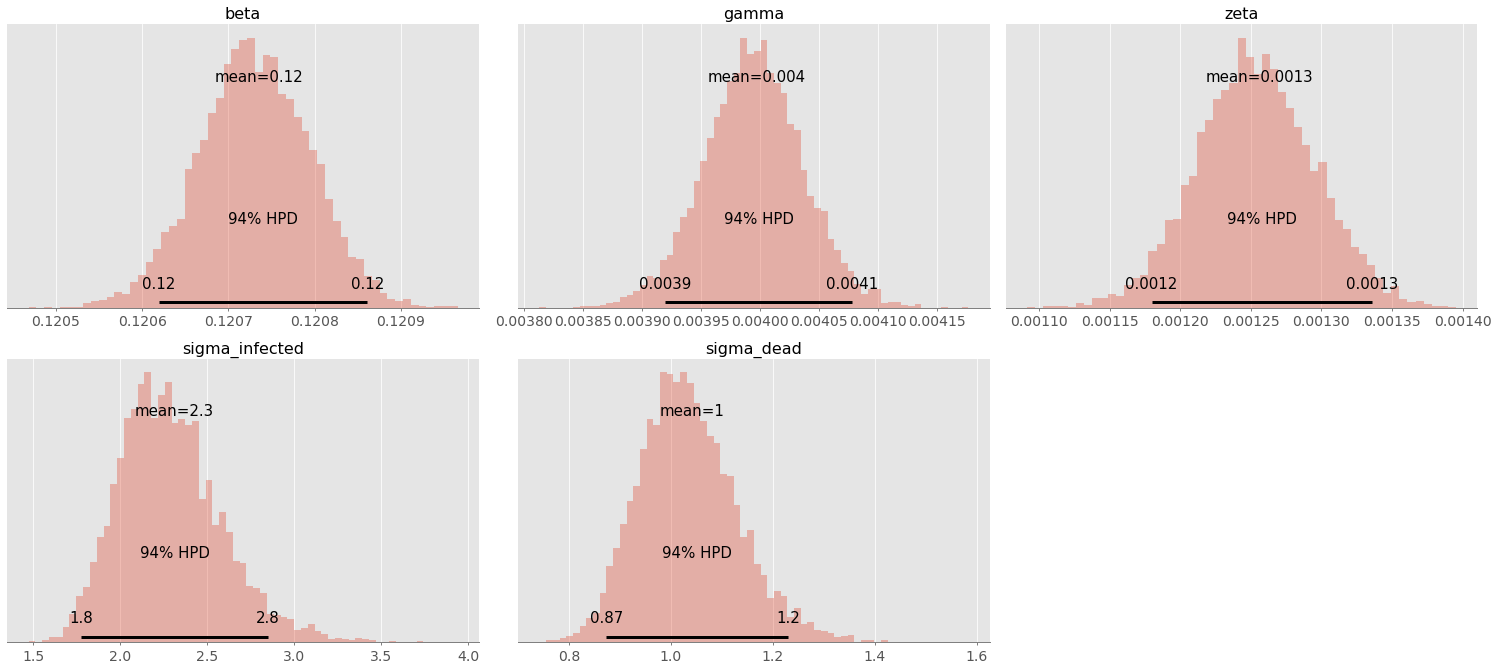

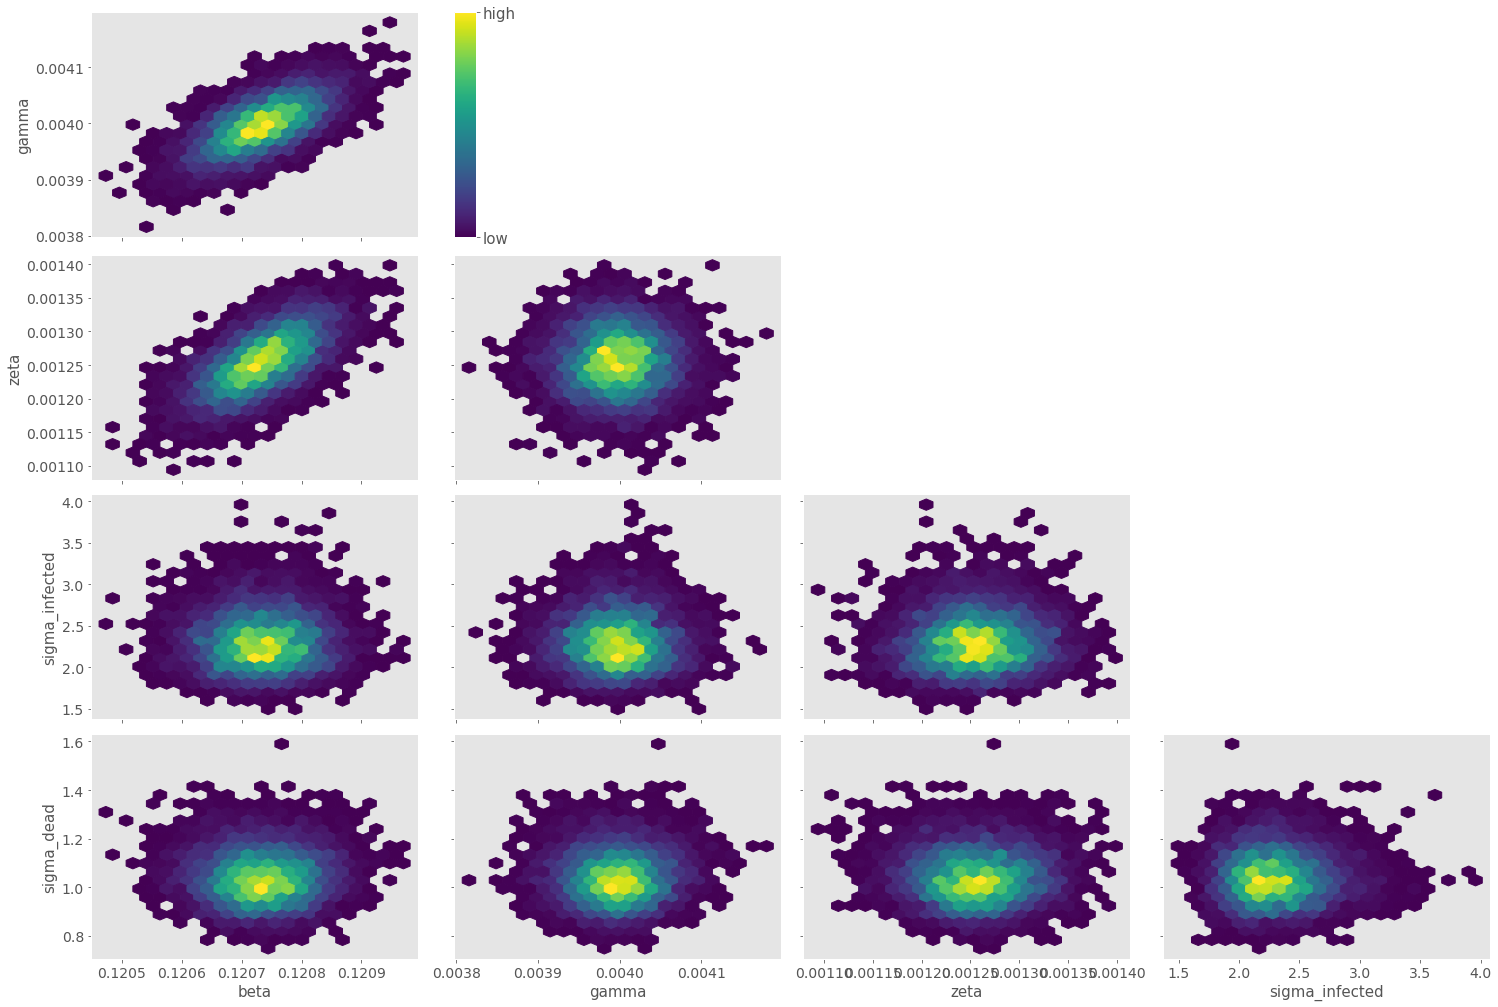

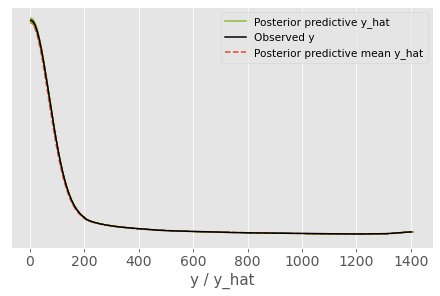

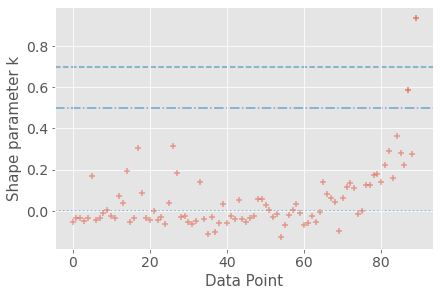

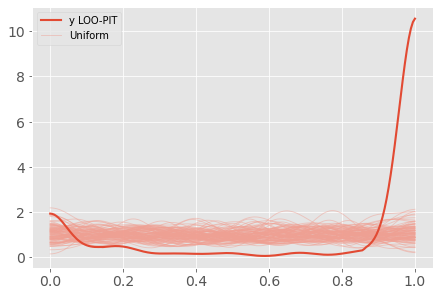

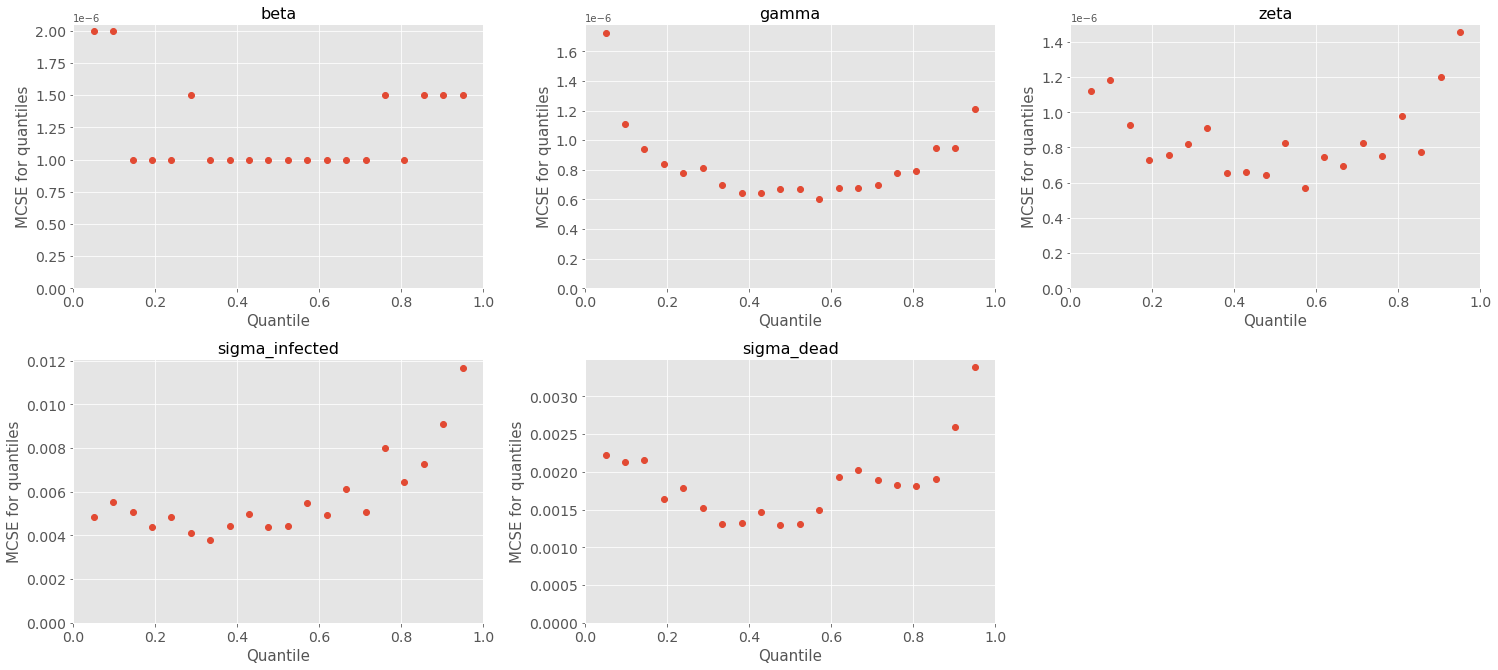

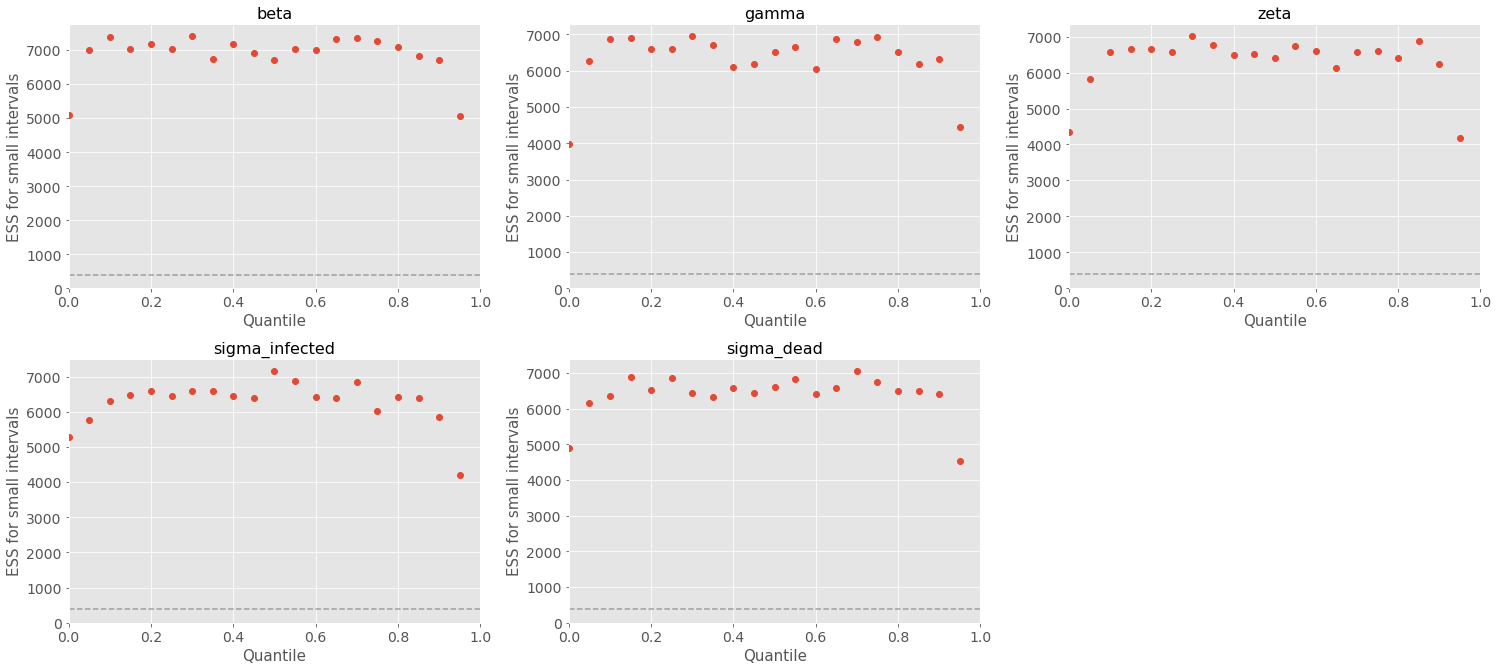

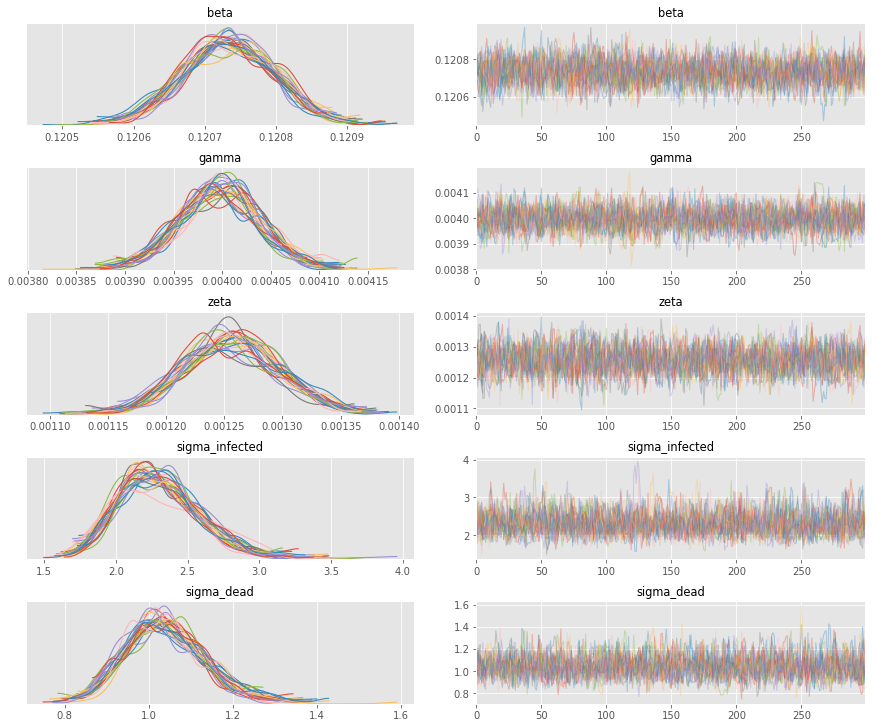

In [236]:
samples.standard_validate_arviz(sim_fit, 'log_likelihood', 'y_hat', sim_comparison.to_numpy(), analysis_variables)

# Inference from data

## Fetch the latest data on the epidemic

In [237]:
curl = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
durl = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
rurl = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

confirmed = pd.read_csv(curl, error_bad_lines=False)
dead = pd.read_csv(durl, error_bad_lines=False)
recovered = pd.read_csv(rurl, error_bad_lines=False)

data_start_index = '1/22/20'

Let's check out some of the earliest data sets.

In [238]:
def subset_country_names(table, countries):
    rose = []
    for country in countries:
        rose.append(confirmed[confirmed['Country/Region'] == country])
    return pd.concat(rose, axis=0)

subset_country_names(confirmed, ['Italy', 'Spain', 'Korea, South', 'Iran'])

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20
16,NaN,Italy,43.0,12.0,0,0,0,0,0,0,...,21157,24747,27980,31506,35713,41035,47021,53578,59138,59138.0
18,NaN,Spain,40.0,-4.0,0,0,0,0,0,0,...,6391,7798,9942,11748,13910,17963,20410,25374,28768,28768.0
156,NaN,"Korea, South",36.0,128.0,1,1,2,2,3,4,...,8086,8162,8236,8320,8413,8565,8652,8799,8897,8897.0
155,NaN,Iran,32.0,53.0,0,0,0,0,0,0,...,12729,13938,14991,16169,17361,18407,19644,20610,21638,21638.0


Configure the observations

In [261]:
data_config = {
    'start_index':data_start_index,
    'start_at_infections':20,
    'start_at_deaths':5,
    'country':'Australia',
    'model_file':'sird_reduced.stan',
}

## Extracting the time-series values

Here we'll pull out just the measurements we have for the specified country and organize them as a single matrix to feed into Stan.

In [262]:
measurements = form_table(data_config, confirmed, recovered, dead).iloc[0:-2, :]
day_count = measurements.shape[0]
measurements.iloc[0, :]

Australia reached 20 "Confirmed" on 2/22/20; dropping preceding data


Confirmed    22.0
Recovered    11.0
Dead          0.0
Name: 2/22/20, dtype: float64

It's always a good idea to take a look at the data we plan to fit to.

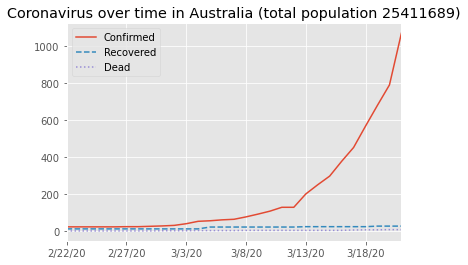

In [263]:
display_measurements(measurements, populations, data_config['country'])

If you plot an early country, you can clearly see the point at which the behavior change caused an inflection point in infections.

In [264]:
fit_data = {**prior_data, **{
    ## Parameters
    'y':measurements.to_numpy(),
    'T':day_count,
    'ts':list(range(0, day_count)),
    'population':populations[data_config['country']],
}}

In [ ]:
fit_model = cmdstanpy.CmdStanModel(stan_file=data_config['model_file'])

fit = fit_model.sample(data=fit_data,
                               show_progress='notebook',
                               # Use a fixed seed so that our runs are deterministic.
                               seed=2222,
                               # This computer has 24 cores/48 threads; 24 chains is plenty
                               cores=24,
                               chains=24,
                               # Make the sampler a bit more robust in exchange for more sampling time
                               adapt_delta=0.,
                               # Let the sampler explore deeper
                               max_treedepth=16,
                               # Make sure to get enough samples to avoid any diagnostic problems
                               iter_sampling=300)

# Generate a run summary
samples.run_validate_stan(fit, important_values)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/peddie/programming/covid19-modelling/sird_reduced


In [ ]:
fit_samples = samples.get_sample_time_series(fit)
plot_posterior_time_series(fit_samples, measurements, data_config)

#### Extended prior diagnostics

We'll use arviz to do some more diagnostic plots.

In [ ]:
samples.standard_validate_arviz(fit, 'log_likelihood', 'y_hat', measurements.to_numpy(), analysis_variables)